In [1]:
!pip install tensorflow matplotlib numpy

In [2]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras import layers, models, saving

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [27]:
data_path = "dataset"
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f'Битый файл удален или пропущен: {img_path}')
                os.remove(img_path)

In [28]:
data_dir = pathlib.Path("dataset")

BATCH_SIZE = 32
IMG_SIZE = (180, 180)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 4611 files belonging to 2 classes.
Using 3689 files for training.
Found 4611 files belonging to 2 classes.
Using 922 files for validation.


In [29]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
])

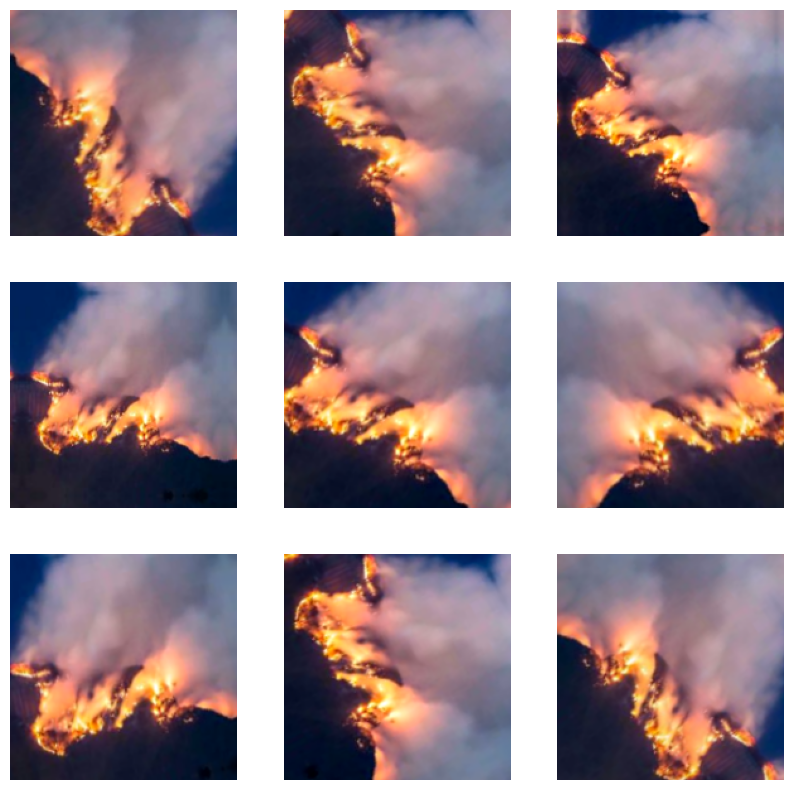

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
# Базовая модель MobileNetV2
# include_top=False — убираем финальный слой классификации ImageNet
base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3),
                                               include_top=False,
                                               weights='imagenet')

# ЗАМОРАЖИВАЕМ веса базовой модели
# Это важно: мы не хотим менять то, что модель уже выучила на ImageNet
base_model.trainable = False

C:\Users\Volodimer\AppData\Local\Temp\ipykernel_11200\82753942.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3),


In [33]:
num_classes = 2

preprocessing_layer = layers.Rescaling(scale=2./255, offset=-1)

model = models.Sequential([
    # 1. Слой аугментации (тот же, что мы создавали ранее)
    data_augmentation,
    
    # 2. Препроцессинг специально для MobileNetV2 
    # (она ожидает значения пикселей в диапазоне [-1, 1])
    preprocessing_layer,
    
    # 3. Сама предобученная база
    base_model,
    
    # 4. Превращаем 3D признаки в 1D вектор с помощью Global Average Pooling
    layers.GlobalAveragePooling2D(),
    
    # 5. Финальный классификатор
    layers.Dropout(0.2),
    layers.Dense(1) # Выход: 1 нейрон (бинарная классификация)
])



In [35]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (32, 6, 6, 1280)       │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (32, 1280)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 1280)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])



early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True 
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-5    
)

epochs = 100

history = model.fit(train_ds, 
                    epochs=epochs, 
                    validation_data=val_ds,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - accuracy: 0.6175 - loss: 0.6532 - val_accuracy: 0.7657 - val_loss: 0.4594 - learning_rate: 1.0000e-04
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.8113 - loss: 0.3955 - val_accuracy: 0.8774 - val_loss: 0.3107 - learning_rate: 1.0000e-04
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.8753 - loss: 0.2899 - val_accuracy: 0.9132 - val_loss: 0.2416 - learning_rate: 1.0000e-04
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.9043 - loss: 0.2497 - val_accuracy: 0.9317 - val_loss: 0.2040 - learning_rate: 1.0000e-04
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.9187 - loss: 0.2068 - val_accuracy: 0.9469 - val_loss: 0.1803 - learning_rate: 1.0000e-04
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.9252 - loss: 0.1907 - val_accuracy: 0.9490 - val_loss: 0.1642 - learning_rate: 1.0000e-04
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━

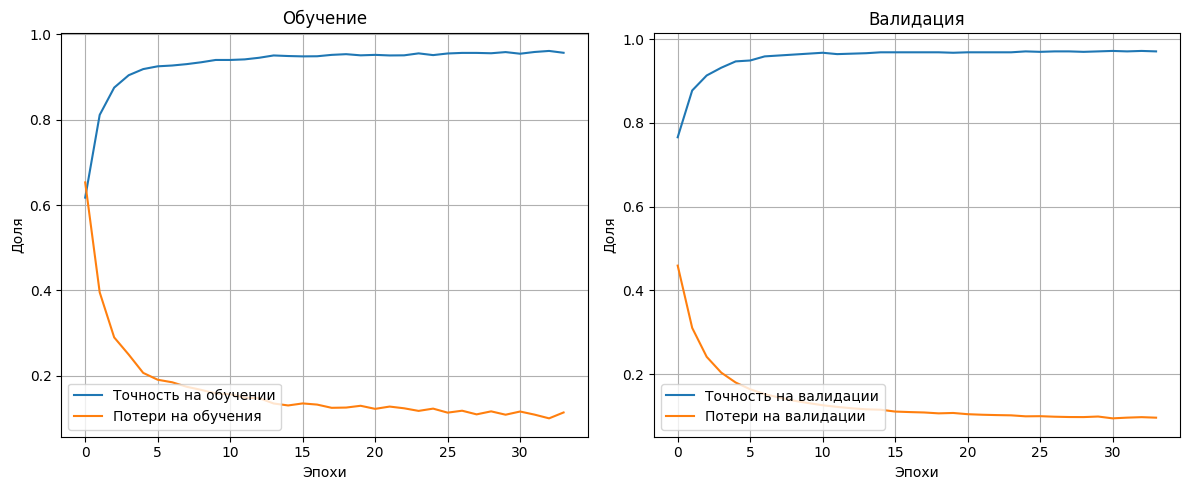

In [37]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Точность на обучении')
    plt.plot(epochs_range, loss, label='Потери на обучения')
    plt.title('Обучение')
    plt.xlabel('Эпохи')
    plt.ylabel('Доля')
    plt.legend(loc='lower left')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_acc, label='Точность на валидации')
    plt.plot(epochs_range, val_loss, label='Потери на валидации')
    plt.title('Валидация')
    plt.xlabel('Эпохи')
    plt.ylabel('Доля')
    plt.legend(loc='lower left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

In [38]:
# Размораживаем всю базовую модель
base_model.trainable = True

# Заморозим все слои ДО 100-го (оставим обучаемыми только верхние слои)
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# ВАЖНО: используйте ОЧЕНЬ маленький шаг обучения (learning rate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True 
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-7   
)

history_fine = model.fit(train_ds,
                         epochs=epochs+5,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[early_stopping, reduce_lr])

Epoch 34/105
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.9217 - loss: 0.2205 - val_accuracy: 0.9729 - val_loss: 0.0877 - learning_rate: 1.0000e-05
Epoch 35/105
116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - accuracy: 0.9444 - loss: 0.1572 - val_accuracy: 0.9740 - val_loss: 0.0832 - learning_rate: 1.0000e-05
Epoch 36/105
116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - accuracy: 0.9463 - loss: 0.1373 - val_accuracy: 0.9740 - val_loss: 0.0726 - learning_rate: 1.0000e-05
Epoch 37/105
116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 204ms/step - accuracy: 0.9564 - loss: 0.1161 - val_accuracy: 0.9751 - val_loss: 0.0702 - learning_rate: 1.0000e-05
Epoch 38/105
116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - accuracy: 0.9615 - loss: 0.1018 - val_accuracy: 0.9761 - val_loss: 0.0677 - learning_rate: 1.0000e-05
Epoch 39/105
116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 204ms/step - accuracy: 0.9650 - loss: 0.0958 - val_accuracy: 0.9751 - val_loss: 0.0671 - learning_rate: 1.0000e-05
Epoch 40/105
116/116 ━━━━━━━━━━━━━

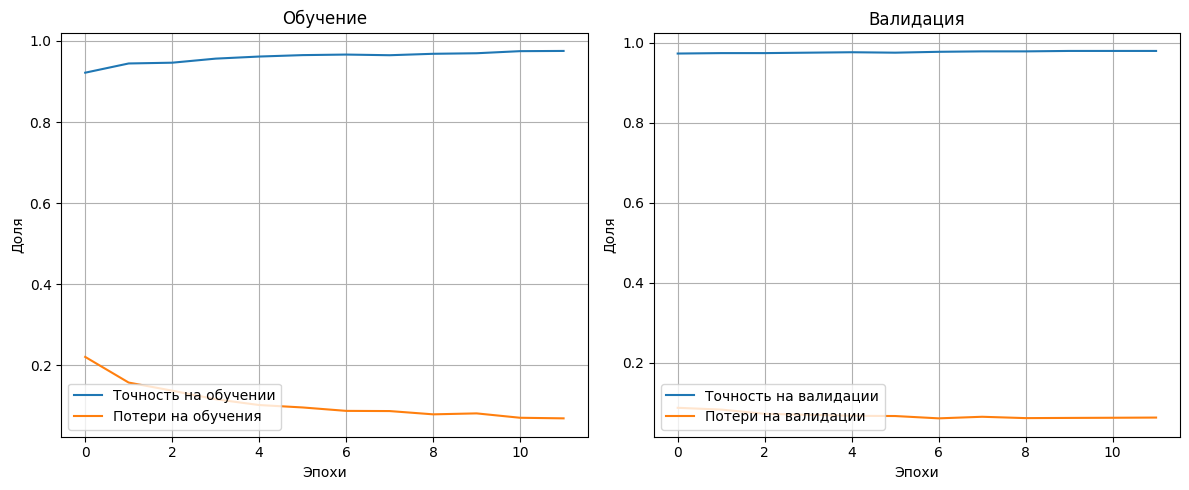

In [39]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Точность на обучении')
    plt.plot(epochs_range, loss, label='Потери на обучения')
    plt.title('Обучение')
    plt.xlabel('Эпохи')
    plt.ylabel('Доля')
    plt.legend(loc='lower left')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_acc, label='Точность на валидации')
    plt.plot(epochs_range, val_loss, label='Потери на валидации')
    plt.title('Валидация')
    plt.xlabel('Эпохи')
    plt.ylabel('Доля')
    plt.legend(loc='lower left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history_fine)

In [41]:
model.save('forest_fire.keras')

In [6]:
model = models.load_model('forest_fire.keras')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('forest_fire.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\VOLODI~1\AppData\Local\Temp\tmpom90m8jy\assets


INFO:tensorflow:Assets written to: C:\Users\VOLODI~1\AppData\Local\Temp\tmpom90m8jy\assets


Saved artifact at 'C:\Users\VOLODI~1\AppData\Local\Temp\tmpom90m8jy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(32, 180, 180, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(32, 1), dtype=tf.float32, name=None)
Captures:
  2489210482256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2489210718864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2489210567168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2489210568224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2489210716752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2489210721856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2489210723088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2489210726960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2489210723616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2489210725728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  24892

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
--- РЕЗУЛЬТАТ ---
Класс: no_fire
Уверенность: 99.89%


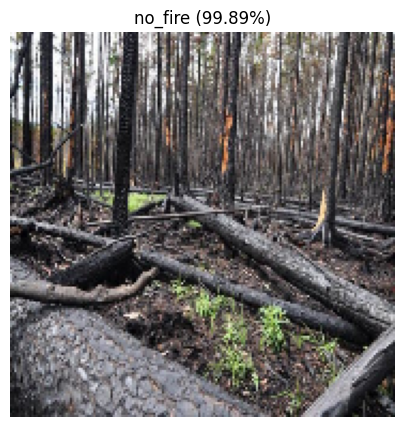

In [4]:
img_path = 'test.jpg' 

img = tf.keras.utils.load_img(
    img_path, target_size=(180, 180)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = float(tf.nn.sigmoid(predictions[0]))

class_names = ['fire', 'no_fire']

if score < 0.5:
    predicted_class = class_names[0]
    confidence = 100 * (1 - score)
else:
    predicted_class = class_names[1]
    confidence = 100 * score

print(f"--- РЕЗУЛЬТАТ ---")
print(f"Класс: {predicted_class}")
print(f"Уверенность: {confidence:.2f}%")

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(f"{predicted_class} ({confidence:.2f}%)")
plt.axis("off")
plt.show()

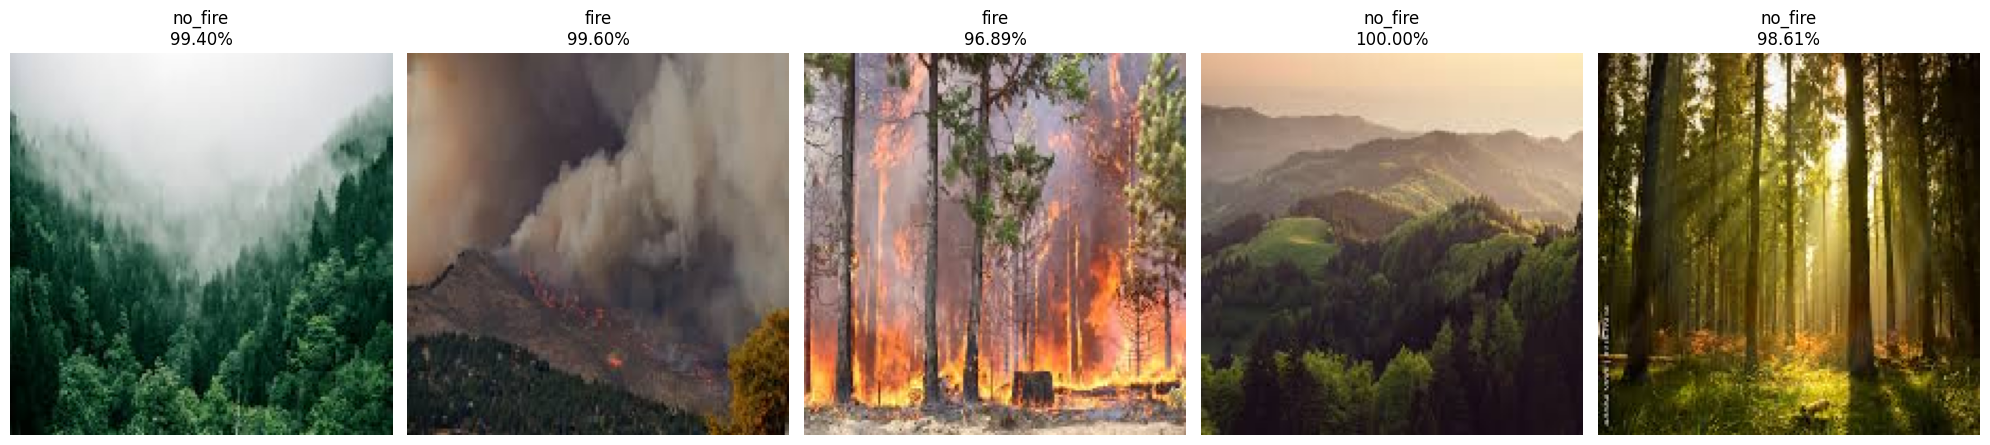

In [7]:
import random


# 1. Загрузка модели (учитываем возможные custom_objects)
# model_path = 'forest_fire.keras'

# model = tf.keras.models.load_model(model_path)


# 2. Настройка путей и параметров
test_dir = 'tests' # Путь к вашей папке с тестами
IMG_SIZE = (180, 180)
# Список классов (убедитесь, что порядок совпадает с вашим обучением)
class_names = ['fire', 'no_fire'] 

# 3. Поиск всех изображений в папке
all_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(all_images) < 5:
    sample_images = all_images
else:
    sample_images = random.sample(all_images, 5)

# 4. Визуализация и предсказание
plt.figure(figsize=(20, 10))

for i, img_path in enumerate(sample_images):
    # Загрузка и подготовка
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_tensor = tf.expand_dims(img_array, 0)

    # Предсказание
    predictions = model.predict(img_tensor, verbose=0)
    score = tf.nn.sigmoid(predictions[0][0]).numpy()

    # Интерпретация (0 - Пожар, 1 - Нет пожара)
    if score < 0.5:
        result_label = class_names[0]
        confidence = (1 - score) * 100
    else:
        result_label = class_names[1]
        confidence = score * 100

    # Отрисовка
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{result_label}\n{confidence:.2f}%")
    plt.axis("off")

plt.tight_layout()
plt.show()